In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from datasets import Dataset
from google.colab import drive
import torch

plt.style.use('ggplot')
%matplotlib inline

In [ ]:
!pip install transformers datasets
from datasets import load_dataset

# 1. Описание набора данных и признаков

In [ ]:
dataset = load_dataset('rotten_tomatoes')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])
validation_df = pd.DataFrame(dataset['validation'])

In [ ]:
train_df.head()

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [ ]:
validation_df.head()

,text,label
0,compassionately explores the seemingly irrecon...,1
1,the soundtrack alone is worth the price of adm...,1
2,rodriguez does a splendid job of racial profil...,1
3,beneath the film's obvious determination to sh...,1
4,bielinsky is a filmmaker of impressive talent .,1


In [ ]:
test_df.head()

,text,label
0,lovingly photographed in the manner of a golde...,1
1,consistently clever and suspenseful .,1
2,"it's like a "" big chill "" reunion of the baade...",1
3,the story gives ample opportunity for large-sc...,1
4,"red dragon "" never cuts corners .",1


In [ ]:
full_df = pd.concat([train_df, validation_df, test_df]) # объединяем в один датасет

In [ ]:
full_df.head()

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10662 entries, 0 to 1065
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10662 non-null  object
 1   label   10662 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 249.9+ KB


In [ ]:
full_df.dtypes

text     object
label     int64
dtype: object

In [ ]:
full_df.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
full_df.describe()

,label
count,10662.000000
mean,0.500000
std,0.500023
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


На основе анализы нам удалось узнать, что:
- всего у нас 10662 записи
- в данных нет пропущенных значений, что является хорошим признаком для последующего анализа без необходимости дополнительной очистки данных
- Статистическое описание меток ("label") показывает, что в данных примерно равное количество положительных и отрицательных отзывов ("mean" ~ 0.5), что указывает на сбалансированность выборки. Это положительно сказывается на обучении модели, так как нет перекоса в сторону одного из классов.



# 2. Ура, посмотрим на графики

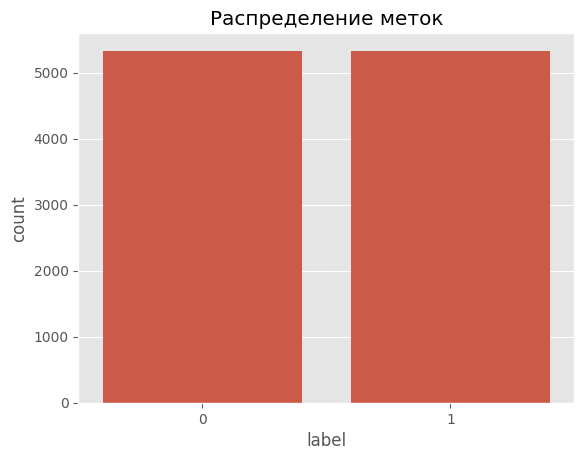

In [ ]:
sns.countplot(x='label', data=full_df)
plt.title('Распределение меток')
plt.show()

На основе этого графика можно заметить, что метки распределены равномерно


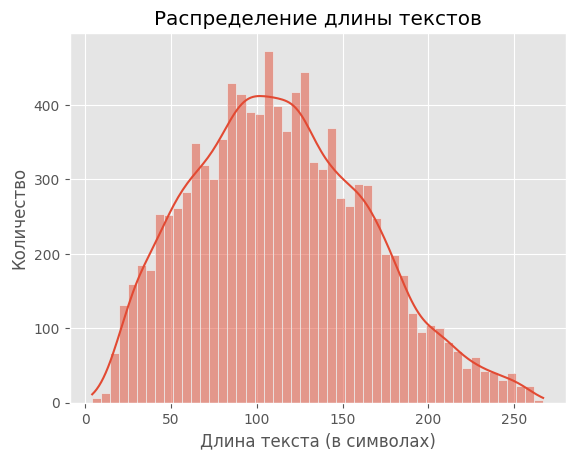

In [ ]:
full_df['text_length'] = full_df['text'].apply(len)
sns.histplot(full_df['text_length'], bins=50, kde=True)
plt.title('Распределение длины текстов')
plt.xlabel('Длина текста (в символах)')
plt.ylabel('Количество')
plt.show()

На основе графика распределения длины текстов можно сделать следующие выводы:
- Распределение длин текстов имеет форму, близкую к нормальному распределению, что характеризуется симметричной формой и одним пиком
- Средняя длина текстов находится примерно в районе 100-120 символов
- Большинство текстов имеют длину от примерно 50 до 150 символов, что указывает на то, что отзывы обычно кратки и сжаты

In [ ]:
print("Примеры положительных отзывов:")
full_df[full_df['label'] == 1]['text'].head()

Примеры положительных отзывов:


0    the rock is destined to be the 21st century's ...
1    the gorgeously elaborate continuation of " the...
2                       effective but too-tepid biopic
3    if you sometimes like to go to the movies to h...
4    emerges as something rare , an issue movie tha...
Name: text, dtype: object

In [ ]:
print("\nПримеры отрицательных отзывов:")
full_df[full_df['label'] == 0]['text'].head()


Примеры отрицательных отзывов:


4265                     simplistic , silly and tedious .
4266    it's so laddish and juvenile , only teenage bo...
4267    exploitative and largely devoid of the depth o...
4268    [garbus] discards the potential for pathologic...
4269    a visually flashy but narratively opaque and e...
Name: text, dtype: object

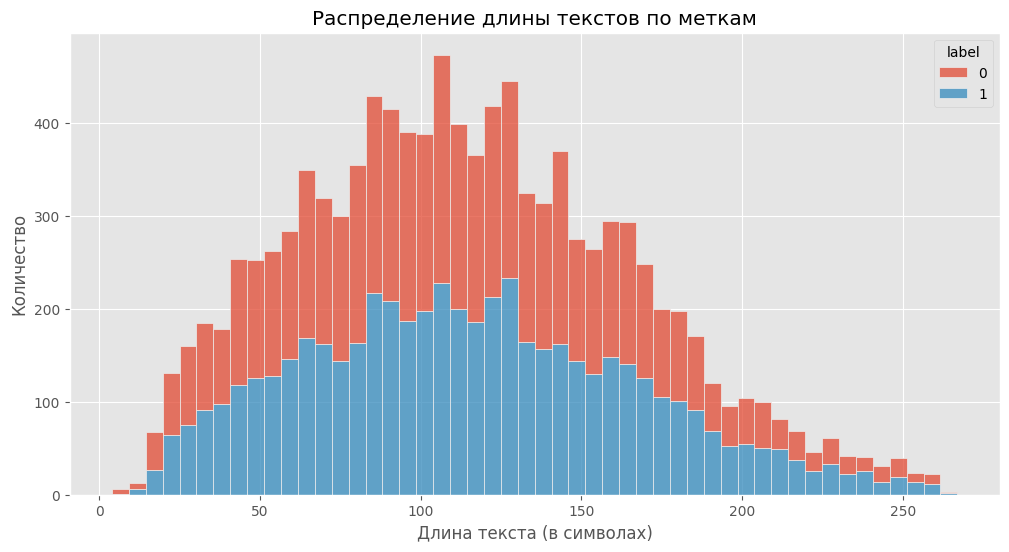

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=full_df, x='text_length', hue='label', multiple='stack', bins=50)
plt.title('Распределение длины текстов по меткам')
plt.xlabel('Длина текста (в символах)')
plt.ylabel('Количество')
plt.show()

Здесь мы видим, что:
-  Тексты с меткой 1 имеют более плотное распределение вокруг более короткой средней длины, около 80-100 символов. Тексты с меткой 0 также следуют примерно нормальному распределению, но средняя длина текстов чуть больше, около 100-120 символов
- Распределение для метки 0 показывает два пика, что может указывать на наличие двух различных типов отрицательных отзывов — одни более краткие, другие более подробные

In [ ]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

positive_text = ' '.join(full_df[full_df['label'] == 1]['text'])
negative_text = ' '.join(full_df[full_df['label'] == 0]['text'])

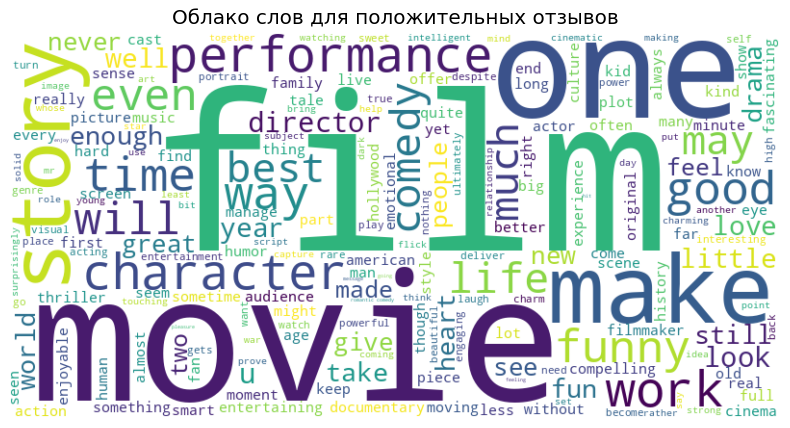

In [ ]:
plot_wordcloud(positive_text, 'Облако слов для положительных отзывов')

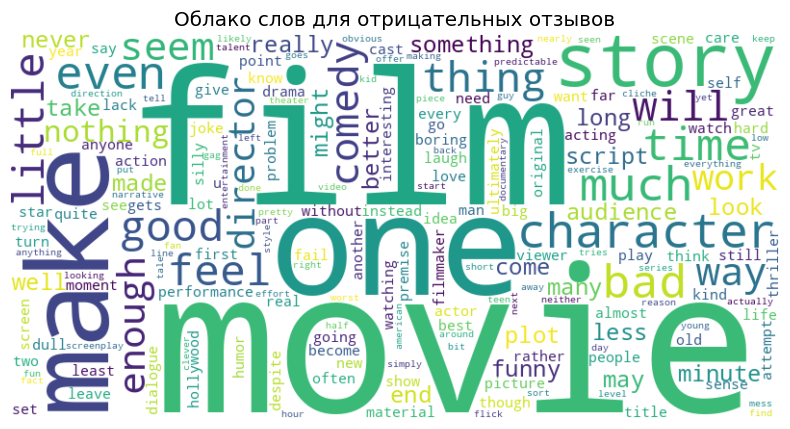

In [ ]:
plot_wordcloud(negative_text, 'Облако слов для отрицательных отзывов')

In [ ]:
positive_words = positive_text.split()
negative_words = negative_text.split()

positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)

print(f"Количество уникальных слов в положительных отзывах: {len(positive_word_counts)}")
print(f"Количество уникальных слов в отрицательных отзывах: {len(negative_word_counts)}")

Количество уникальных слов в положительных отзывах: 14068
Количество уникальных слов в отрицательных отзывах: 14508


In [ ]:
def get_top_ngrams(corpus, ngram_range=(2, 2), n=None):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

top_positive_bigrams = get_top_ngrams(full_df[full_df['label'] == 1]['text'], ngram_range=(2, 2), n=10)
top_negative_bigrams = get_top_ngrams(full_df[full_df['label'] == 0]['text'], ngram_range=(2, 2), n=10)

top_positive_trigrams = get_top_ngrams(full_df[full_df['label'] == 1]['text'], ngram_range=(3, 3), n=10)
top_negative_trigrams = get_top_ngrams(full_df[full_df['label'] == 0]['text'], ngram_range=(3, 3), n=10)

print(f"Топ-10 биграмм в положительных отзывах: {top_positive_bigrams}")
print(f"Топ-10 биграмм в отрицательных отзывах: {top_negative_bigrams}")

print(f"Топ-10 триграмм в положительных отзывах: {top_positive_trigrams}")
print(f"Топ-10 триграмм в отрицательных отзывах: {top_negative_trigrams}")

Топ-10 биграмм в положительных отзывах: [('of the', 707), ('the film', 357), ('in the', 303), ('and the', 210), ('to the', 197), ('it is', 170), ('but it', 166), ('to be', 161), ('one of', 155), ('the movie', 142)]
Топ-10 биграмм в отрицательных отзывах: [('of the', 496), ('in the', 327), ('the film', 311), ('the movie', 269), ('to be', 209), ('to the', 189), ('and the', 162), ('for the', 159), ('on the', 143), ('it is', 111)]
Топ-10 триграмм в положительных отзывах: [('one of the', 101), ('the film is', 68), ('of the year', 37), ('of the most', 35), ('the kind of', 35), ('coming of age', 33), ('the movie is', 33), ('of the best', 31), ('if you re', 30), ('as it is', 30)]
Топ-10 триграмм в отрицательных отзывах: [('the movie is', 62), ('the film is', 60), ('one of the', 38), ('the kind of', 32), ('one of those', 26), ('of the film', 25), ('most of the', 25), ('the fact that', 25), ('in the end', 24), ('if you re', 23)]


In [ ]:
def plot_ngrams(ngrams, title):
    ngrams_df = pd.DataFrame(ngrams, columns=['ngram', 'count'])
    plt.figure(figsize=(8, 4))
    colors = plt.cm.viridis(ngrams_df['count'] / max(ngrams_df['count']))
    ngrams_df.plot(kind='bar', x='ngram', y='count', legend=False, color=colors, edgecolor='black')
    plt.title(title)
    plt.ylabel('Частота')
    plt.xlabel('N-граммы')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

<Figure size 800x400 with 0 Axes>

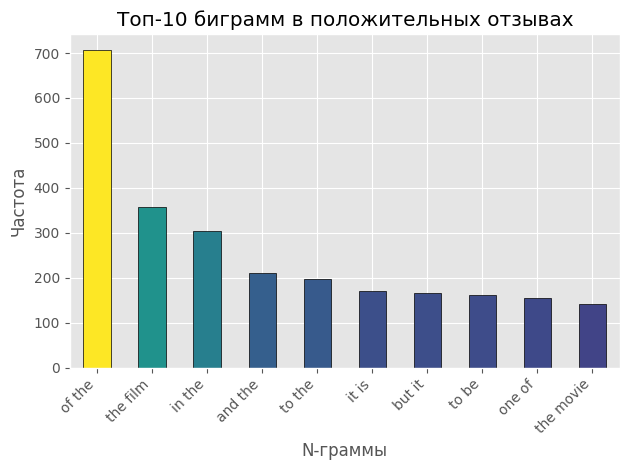

In [ ]:
plot_ngrams(top_positive_bigrams, 'Топ-10 биграмм в положительных отзывах')

<Figure size 800x400 with 0 Axes>

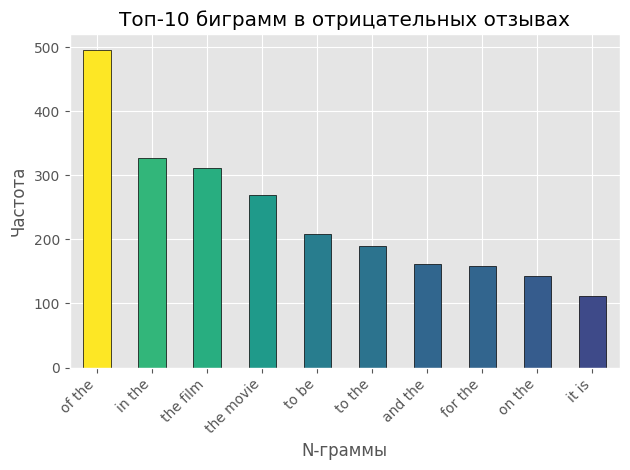

In [ ]:
plot_ngrams(top_negative_bigrams, 'Топ-10 биграмм в отрицательных отзывах')

<Figure size 800x400 with 0 Axes>

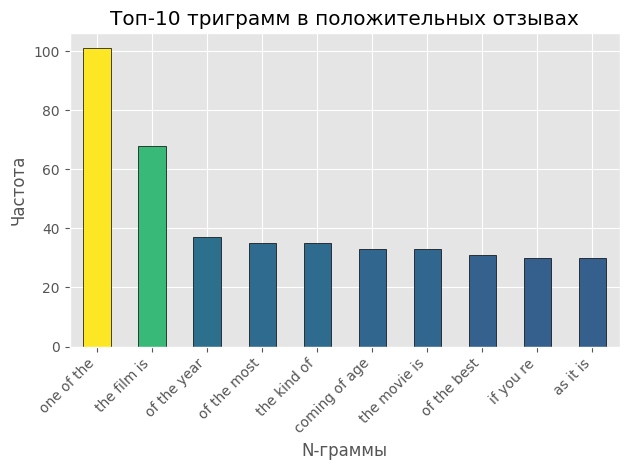

In [ ]:
plot_ngrams(top_positive_trigrams, 'Топ-10 триграмм в положительных отзывах')

<Figure size 800x400 with 0 Axes>

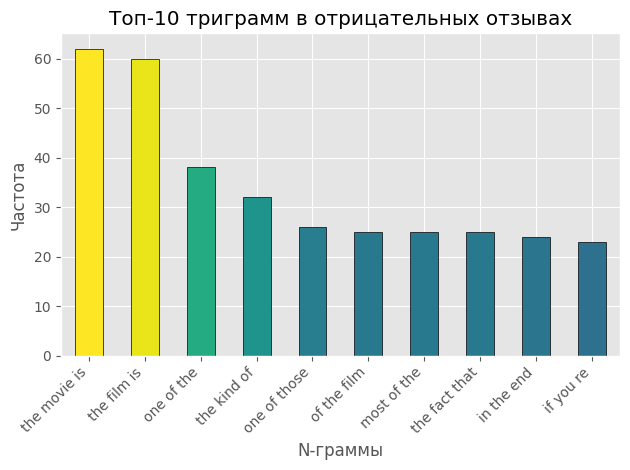

In [ ]:
plot_ngrams(top_negative_trigrams, 'Топ-10 триграмм в отрицательных отзывах')

# 3. Предварительная обработка текстов

In [ ]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    clean_text = ' '.join(tokens)
    return clean_text

train_df['clean_text'] = train_df['text'].apply(preprocess_text)
test_df['clean_text'] = test_df['text'].apply(preprocess_text)
validation_df['clean_text'] = validation_df['text'].apply(preprocess_text)

train_df_clean_head = train_df[['text', 'clean_text']].head()
test_df_clean_head = test_df[['text', 'clean_text']].head()
validation_df_clean_head = validation_df[['text', 'clean_text']].head()

print("Train Data Clean Head:")
print(train_df_clean_head)
print("\nTest Data Clean Head:")
print(test_df_clean_head)
print("\nValidation Data Clean Head:")
print(validation_df_clean_head)

Train Data Clean Head:
                                                text  \
0  the rock is destined to be the 21st century's ...   
1  the gorgeously elaborate continuation of " the...   
2                     effective but too-tepid biopic   
3  if you sometimes like to go to the movies to h...   
4  emerges as something rare , an issue movie tha...   

                                          clean_text  
0  rock destined 21st century new conan he going ...  
1  gorgeously elaborate continuation lord ring tr...  
2                          effective tootepid biopic  
3  sometimes like go movie fun wasabi good place ...  
4  emerges something rare issue movie thats hones...  

Test Data Clean Head:
                                                text  \
0  lovingly photographed in the manner of a golde...   
1              consistently clever and suspenseful .   
2  it's like a " big chill " reunion of the baade...   
3  the story gives ample opportunity for large-sc...   
4      

<ipython-input-32-4105b39e614f>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='bigram', data=bigram_df, palette='viridis')


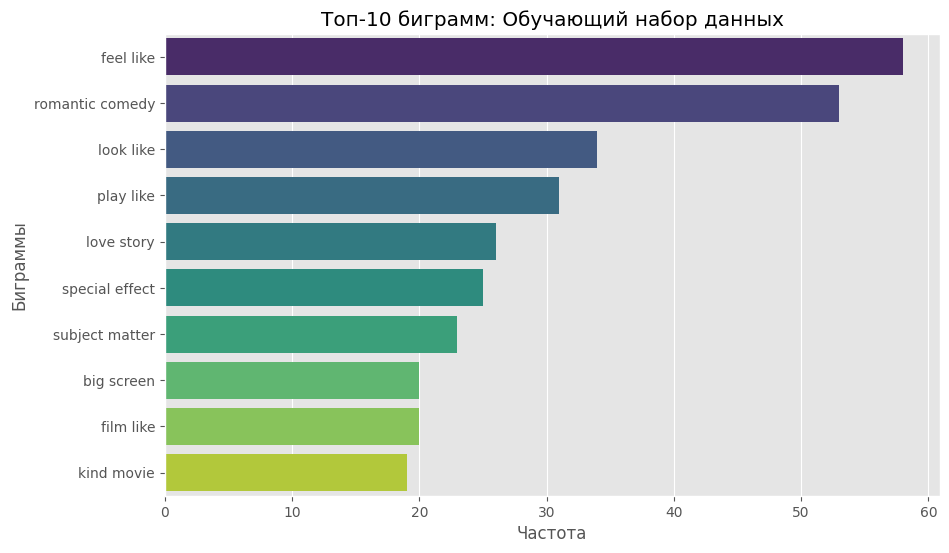

<ipython-input-32-4105b39e614f>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='bigram', data=bigram_df, palette='viridis')


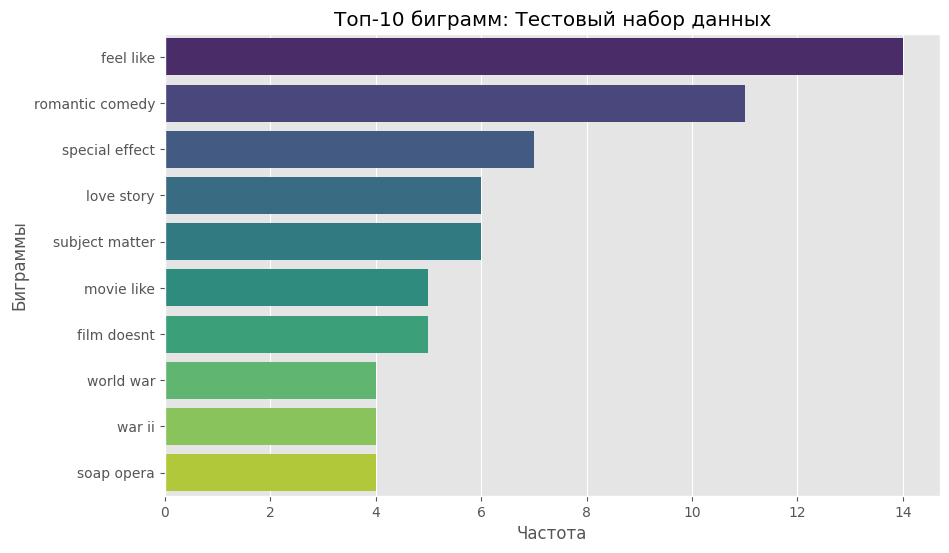

<ipython-input-32-4105b39e614f>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='bigram', data=bigram_df, palette='viridis')


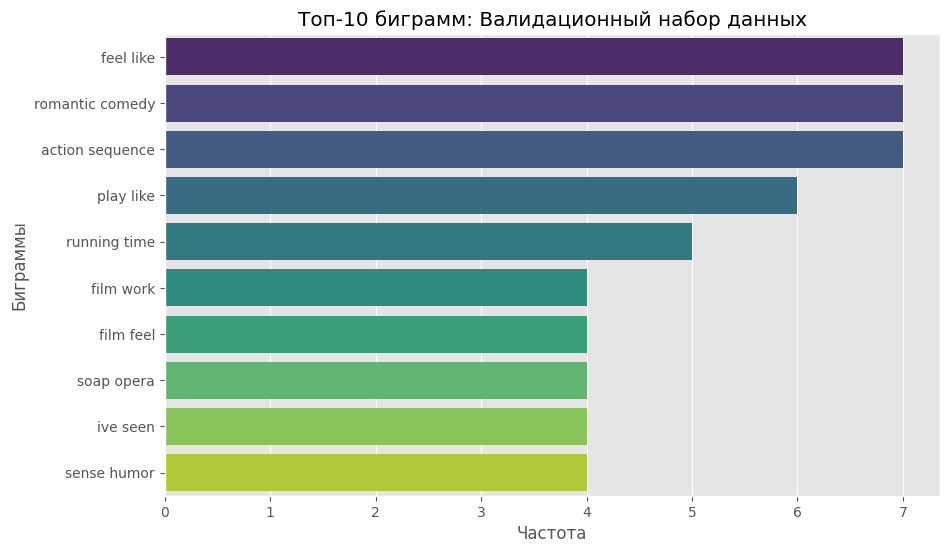

In [ ]:
def analyze_bigrams(df, title):
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    bigrams = vectorizer.fit_transform(df['clean_text'])
    bigram_freq = bigrams.sum(axis=0).A1
    bigram_names = vectorizer.get_feature_names_out()
    bigram_df = pd.DataFrame({'bigram': bigram_names, 'frequency': bigram_freq})
    bigram_df = bigram_df.sort_values(by='frequency', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='frequency', y='bigram', data=bigram_df, palette='viridis')
    plt.title(f'Топ-10 биграмм: {title}')
    plt.xlabel('Частота')
    plt.ylabel('Биграммы')
    plt.show()

analyze_bigrams(train_df, 'Обучающий набор данных')

analyze_bigrams(test_df, 'Тестовый набор данных')

analyze_bigrams(validation_df, 'Валидационный набор данных')

# 4. Основная часть

In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
validation_dataset = Dataset.from_pandas(validation_df)

def tokenize(batch):
    return tokenizer(batch['clean_text'], padding='max_length', truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)
validation_dataset = validation_dataset.map(tokenize, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
validation_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
def mixup_embeddings(embeddings, labels, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = embeddings.size(0)
    index = torch.randperm(batch_size)

    mixed_embeddings = lam * embeddings + (1 - lam) * embeddings[index, :]
    labels_a, labels_b = labels, labels[index]

    return mixed_embeddings, labels_a, labels_b, lam


In [ ]:
!pip install accelerate --upgrade
!pip install transformers --upgrade
!pip install datasets --upgrade
!pip install torch --upgrade

In [ ]:
from torch.nn import functional as F
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

class MixupTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        embeddings = model.bert.embeddings.word_embeddings(inputs['input_ids'])
        mixed_embeddings, labels_a, labels_b, lam = mixup_embeddings(embeddings, labels)

        outputs = model(inputs_embeds=mixed_embeddings, attention_mask=inputs['attention_mask'])
        logits = outputs.logits

        loss = mixup_criterion(F.cross_entropy, logits, labels_a, labels_b, lam)

        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

trainer = MixupTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.559400,0.504882
2,0.540800,0.461384
3,0.353900,0.491340


TrainOutput(global_step=1602, training_loss=0.4996620436732689, metrics={'train_runtime': 3460.5187, 'train_samples_per_second': 7.395, 'train_steps_per_second': 0.463, 'total_flos': 6733011906662400.0, 'train_loss': 0.4996620436732689, 'epoch': 3.0})

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.488290399312973, 'eval_runtime': 64.8347, 'eval_samples_per_second': 16.442, 'eval_steps_per_second': 0.262, 'epoch': 3.0}


In [ ]:
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')